# GITHUB

In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install yfinance
import yfinance as yf

  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --------------------------- ------------ 2.1/3.0 MB 11.3 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 11.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 12.1 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139098 sha256=13e05ec404ec6f71fd781888aedd045f19b7ed4d52620b8a760f064dca10b6eb
  Stored i


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf

# Define the stock ticker and time period
ticker = "SPX"  # Example: Apple Inc.
start_date = "2014-01-01"
end_date = "2024-01-01"

# Fetch historical data
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# Save to CSV
data.to_csv(f"{ticker}.csv")

[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd
df = pd.read_csv(f"{ticker}.csv", skiprows=[0, 1])  # Skips first two rows

# Rename columns correctly
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
# You can adjust the window (here, 14 periods)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
short_ema = df['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
long_ema = df['Close'].ewm(span=26, adjust=False).mean()   # 26-day EMA
#Moving Average Convergence Divergence(MACD)
df['MACD'] = short_ema - long_ema  # MACD line
#ewm calcualted exponetial weighted functions
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df = df.iloc[14:]
df.to_csv(f"{ticker}_test.csv")


In [5]:
#Official Phase Space Reconstructed Neural ODEs (PSR-NODE or NODE in general)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close', 'MACD', 'Signal Line']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = f'{ticker}_test.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)

    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.17538323998451233, Val Loss: 0.060105402022600174
Epoch 10, Train Loss: 0.02716093324124813, Val Loss: 0.02006138488650322
Early stopping triggered at epoch 17
Epoch 0, Train Loss: 0.018661856651306152, Val Loss: 0.071177177131176
Epoch 10, Train Loss: 0.011663584038615227, Val Loss: 0.02803373523056507
Epoch 20, Train Loss: 0.0057644834741950035, Val Loss: 0.011698512360453606
Epoch 30, Train Loss: 0.002122158883139491, Val Loss: 0.0016610135789960623
Epoch 40, Train Loss: 0.0024087978526949883, Val Loss: 0.0006896816194057465
Epoch 50, Train Loss: 0.0018806748557835817, Val Loss: 0.001384285162203014
Early stopping triggered at epoch 52
Epoch 0, Train Loss: 0.0016729634953662753, Val Loss: 0.0033955539111047983
Epoch 10, Train Loss: 0.0015823140274733305, Val Loss: 0.002633374184370041
Epoch 20, Train Loss: 0.0015417613321915269, Val Loss: 0.00251192320138216
Epoch 30, Train Loss: 0.0014753759605810046, Val Loss: 0.0024438209366053343
Epoch 40, Train Loss: 0.00

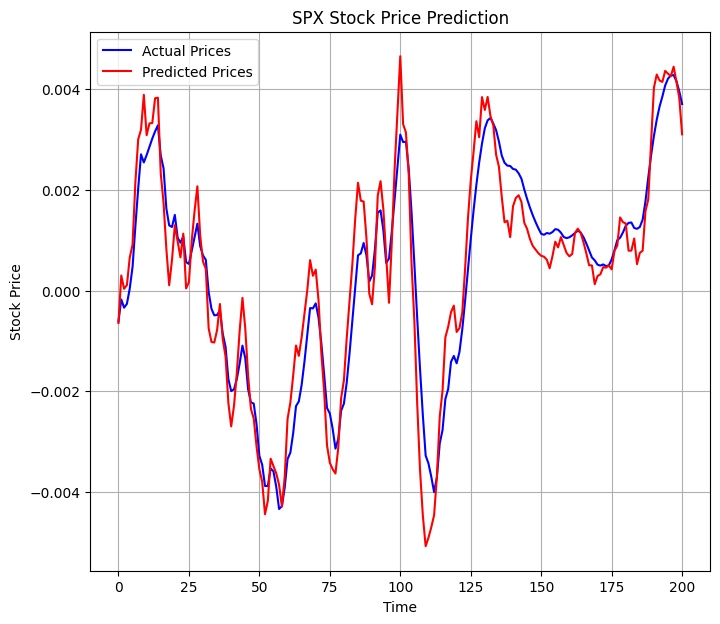

In [6]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

=== Trading Strategy Performance ===
Initial Capital: $10000.00
Final Portfolio Value: $9391.08
Total Return: -6.09%
Buy and Hold Return: -10.83%
Total Trades: 68
  Buy: 19, Sell: 19
  Short: 15, Cover: 15


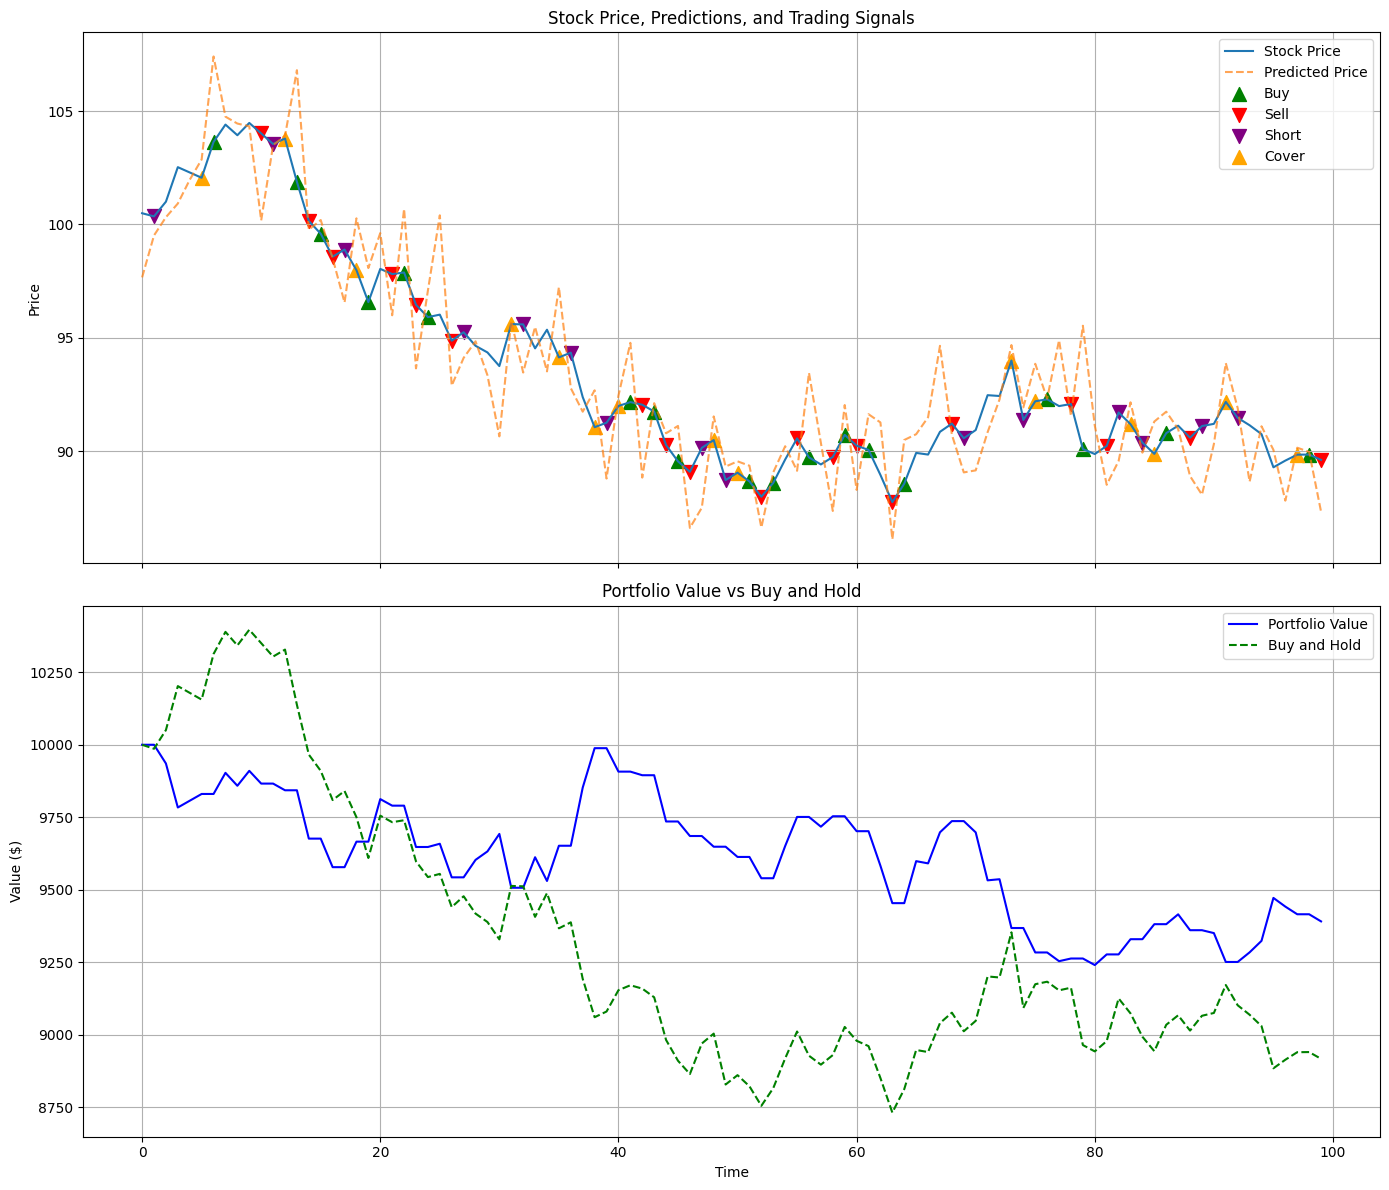

Trading signals saved to 'trading_signals.csv'


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_trading_signals(actual_prices, predicted_prices):
    """
    Generate trading signals based on Neural ODE predictions.
    
    Args:
        actual_prices: Array of actual stock prices
        predicted_prices: Array of predicted prices from Neural ODE model
        
    Returns:
        List of trading signals (BUY, SELL, SHORT, BUY_TO_COVER, HOLD)
    """
    signals = []
    position = 0  # 0: no position, 1: long, -1: short
    
    # For the first day, we don't have a prediction yet
    signals.append('HOLD')
    
    for i in range(1, len(predicted_prices)):
        # Predict price change direction for the next day
        price_change = predicted_prices[i] - actual_prices[i-1]
        
        if position == 0:  # No current position
            if price_change > 0:
                signals.append('BUY')
                position = 1
            elif price_change < 0:
                signals.append('SHORT')
                position = -1
            else:
                signals.append('HOLD')
        
        elif position == 1:  # Currently long
            if price_change > 0:
                signals.append('HOLD')
            else:
                signals.append('SELL')
                position = 0
        
        elif position == -1:  # Currently short
            if price_change < 0:
                signals.append('HOLD')
            else:
                signals.append('BUY_TO_COVER')
                position = 0
    
    return signals

def calculate_portfolio_value(prices, signals, initial_capital=10000):
    """
    Calculate portfolio value based on trading signals.
    
    Args:
        prices: Array of stock prices
        signals: List of trading signals
        initial_capital: Initial portfolio value
        
    Returns:
        List of portfolio values over time
    """
    portfolio_value = [initial_capital]
    position = 0  # 0: no position, 1: long, -1: short
    shares = 0
    
    for i in range(1, len(signals)):
        current_value = portfolio_value[-1]
        
        if signals[i] == 'BUY':
            position = 1
            shares = current_value / prices[i]
            portfolio_value.append(current_value)  # Value doesn't change on buy day
        
        elif signals[i] == 'SELL':
            position = 0
            current_value = shares * prices[i]
            shares = 0
            portfolio_value.append(current_value)
        
        elif signals[i] == 'SHORT':
            position = -1
            shares = current_value / prices[i]
            portfolio_value.append(current_value)  # Value doesn't change on short day
        
        elif signals[i] == 'BUY_TO_COVER':
            position = 0
            current_value = current_value + (shares * (prices[i-1] - prices[i]))
            shares = 0
            portfolio_value.append(current_value)
        
        else:  # HOLD
            if position == 1:
                portfolio_value.append(shares * prices[i])
            elif position == -1:
                profit_or_loss = shares * (prices[i-1] - prices[i])
                portfolio_value.append(portfolio_value[-1] + profit_or_loss)
            else:
                portfolio_value.append(current_value)
    
    return portfolio_value

def visualize_trading_strategy(prices, predicted_prices, dates=None):
    """
    Generate trading signals, calculate portfolio value, and visualize results.
    
    Args:
        prices: Array of actual stock prices
        predicted_prices: Array of predicted prices from Neural ODE model
        dates: Optional array of dates for visualization
        
    Returns:
        Dictionary with trading signals, portfolio values, and performance metrics
    """
    # Generate trading signals
    signals = generate_trading_signals(prices, predicted_prices)
    
    # Calculate portfolio value
    portfolio_value = calculate_portfolio_value(prices, signals)
    
    # Calculate performance metrics
    initial_capital = 10000
    final_value = portfolio_value[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_and_hold_return = (prices[-1] - prices[0]) / prices[0] * 100
    
    # Count the number of trades
    buy_count = signals.count('BUY')
    sell_count = signals.count('SELL')
    short_count = signals.count('SHORT')
    cover_count = signals.count('BUY_TO_COVER')
    total_trades = buy_count + sell_count + short_count + cover_count
    
    # Print performance summary
    print("=== Trading Strategy Performance ===")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Buy and Hold Return: {buy_and_hold_return:.2f}%")
    print(f"Total Trades: {total_trades}")
    print(f"  Buy: {buy_count}, Sell: {sell_count}")
    print(f"  Short: {short_count}, Cover: {cover_count}")
    
    # Prepare data for visualization
    data = pd.DataFrame({
        'Price': prices,
        'Predicted_Price': predicted_prices,
        'Signal': signals,
        'Portfolio_Value': portfolio_value
    })
    
    if dates is not None and len(dates) == len(prices):
        data['Date'] = dates
        x_axis = data['Date']
    else:
        x_axis = data.index
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # Plot stock prices and signals
    ax1.plot(x_axis, data['Price'], label='Stock Price')
    ax1.plot(x_axis, data['Predicted_Price'], label='Predicted Price', linestyle='--', alpha=0.7)
    
    # Add markers for buy and sell signals
    buy_signals = data.index[data['Signal'] == 'BUY'].tolist()
    sell_signals = data.index[data['Signal'] == 'SELL'].tolist()
    short_signals = data.index[data['Signal'] == 'SHORT'].tolist()
    cover_signals = data.index[data['Signal'] == 'BUY_TO_COVER'].tolist()
    
    if buy_signals:
        ax1.scatter(x_axis[buy_signals], data['Price'].iloc[buy_signals], 
                   marker='^', color='green', s=100, label='Buy')
    if sell_signals:
        ax1.scatter(x_axis[sell_signals], data['Price'].iloc[sell_signals], 
                   marker='v', color='red', s=100, label='Sell')
    if short_signals:
        ax1.scatter(x_axis[short_signals], data['Price'].iloc[short_signals], 
                   marker='v', color='purple', s=100, label='Short')
    if cover_signals:
        ax1.scatter(x_axis[cover_signals], data['Price'].iloc[cover_signals], 
                   marker='^', color='orange', s=100, label='Cover')
    
    ax1.set_title('Stock Price, Predictions, and Trading Signals')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    ax1.legend()
    
    # Plot portfolio value
    ax2.plot(x_axis, data['Portfolio_Value'], label='Portfolio Value', color='blue')
    
    # Add buy-and-hold line for comparison
    buy_hold_values = [initial_capital * (price / prices[0]) for price in prices]
    ax2.plot(x_axis, buy_hold_values, label='Buy and Hold', color='green', linestyle='--')
    
    ax2.set_title('Portfolio Value vs Buy and Hold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Value ($)')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('trading_strategy_results.png')
    plt.show()
    
    # Compile results
    results = {
        'signals': signals,
        'portfolio_value': portfolio_value,
        'total_return': total_return,
        'buy_and_hold_return': buy_and_hold_return,
        'total_trades': total_trades,
        'trade_counts': {
            'buy': buy_count,
            'sell': sell_count,
            'short': short_count,
            'cover': cover_count
        }
    }
    
    return results

def save_trading_signals(prices, predicted_prices, signals, portfolio_value, dates=None, file_name='trading_signals.csv'):
    """
    Save trading signals and results to a CSV file.
    
    Args:
        prices: Array of stock prices
        predicted_prices: Array of predicted prices
        signals: List of trading signals
        portfolio_value: List of portfolio values
        dates: Optional array of dates
        file_name: Name of the output CSV file
    """
    if dates is not None and len(dates) == len(prices):
        data = pd.DataFrame({
            'Date': dates,
            'Price': prices,
            'Predicted_Price': predicted_prices,
            'Signal': signals,
            'Portfolio_Value': portfolio_value
        })
    else:
        data = pd.DataFrame({
            'Price': prices,
            'Predicted_Price': predicted_prices,
            'Signal': signals,
            'Portfolio_Value': portfolio_value
        })
    
    data.to_csv(file_name, index=False)
    print(f"Trading signals saved to '{file_name}'")

# Example usage:
if __name__ == "__main__":
    # This is a standalone example - in practice, you would use the Neural ODE predictions 
    # from the notebook instead of this dummy data
    import numpy as np
    
    # Generate dummy data
    np.random.seed(42)
    n_days = 100
    prices = np.cumsum(np.random.normal(0, 1, n_days)) + 100
    predicted_prices = prices + np.random.normal(0, 2, n_days)
    
    # Apply the trading strategy
    results = visualize_trading_strategy(prices, predicted_prices)
    
    # Save the signals to CSV
    save_trading_signals(prices, predicted_prices, results['signals'], results['portfolio_value']) 


PERFORMANCE METRICS COMPARISON
                      Metric Trading Strategy Buy and Hold
            Total Return (%)            -6.09       -10.83
       Annualized Return (%)           -14.17       -24.42
       Mean Daily Return (%)          -0.0606      -0.1110
        Daily Volatility (%)           0.7511       0.9651
   Annualized Volatility (%)            11.92        15.32
                Sharpe Ratio            -1.19        -1.59
        Maximum Drawdown (%)            -7.59       -16.01
Max Drawdown Duration (days)               80           54
                Win Rate (%)            35.29          N/A
               Profit Factor             0.73          N/A


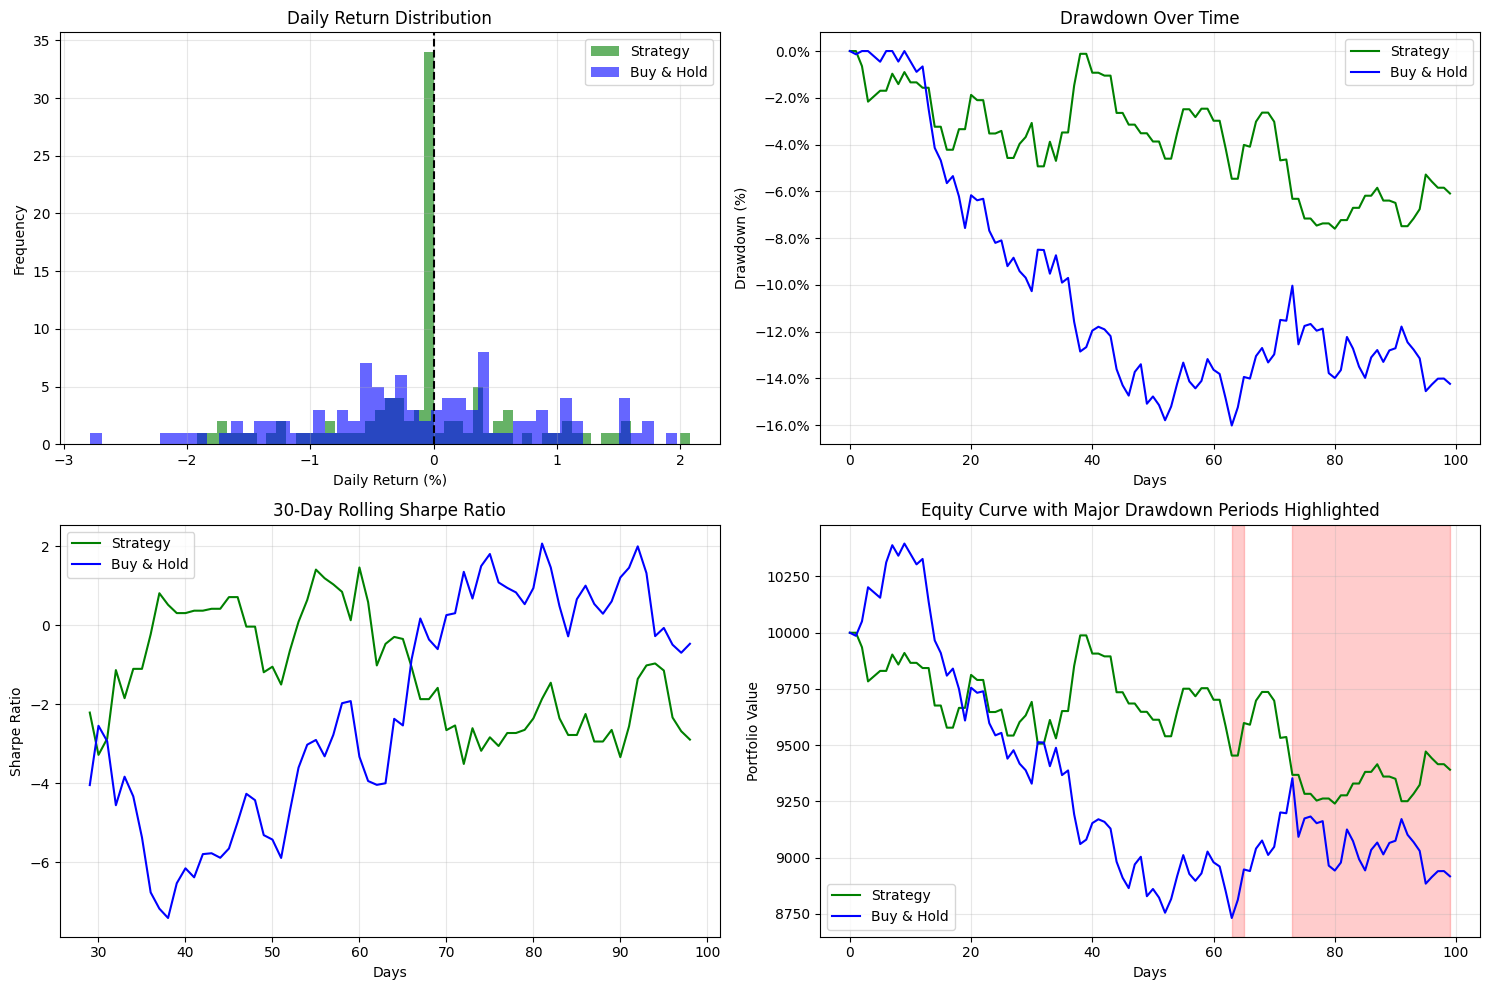


ADVANCED PERFORMANCE METRICS
                Metric Trading Strategy Buy and Hold
          Calmar Ratio            -1.87        -1.53
         Sortino Ratio          -180.00      -251.03
     Positive Days (%)            29.29        45.45
  Max Consecutive Wins                3          N/A
Max Consecutive Losses                7          N/A


In [9]:
#############################################################################
# Cell: Calculate and Display Advanced Performance Metrics
#############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Calculate daily returns from portfolio values
portfolio_values = np.array(results['portfolio_value'])
daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

# Calculate buy and hold values if not already in results
if 'buy_and_hold' not in results:
    # Get the first and last price from the data used to generate signals
    # This assumes we have access to the original prices
    try:
        # If we used neural_ode_trading_strategy.py implementation
        first_price = actual_prices[0]
        prices = actual_prices
    except NameError:
        # If we're using the original implementation
        # Look for the prices in the scope
        if 'prices' in globals():
            first_price = prices[0]
        else:
            print("Warning: Cannot find price data. Using a dummy buy-and-hold curve.")
            first_price = portfolio_values[0] / 10000  # Approximate
            prices = np.linspace(first_price, first_price * portfolio_values[-1] / portfolio_values[0], len(portfolio_values))
    
    # Calculate buy and hold values
    initial_capital = portfolio_values[0]
    buy_and_hold = [initial_capital]
    for i in range(1, len(prices)):
        buy_and_hold.append(initial_capital * (prices[i] / prices[0]))
    
    # Create buy_and_hold key in results
    results['buy_and_hold'] = buy_and_hold
    
    # Calculate buy and hold return
    if 'buy_and_hold_return' not in results:
        results['buy_and_hold_return'] = (buy_and_hold[-1] / buy_and_hold[0] - 1) * 100

# Get buy and hold values
buy_hold_values = np.array(results['buy_and_hold'])
buy_hold_daily_returns = np.diff(buy_hold_values) / buy_hold_values[:-1]

# Calculate performance metrics
mean_daily_return = np.mean(daily_returns) * 100
std_daily_return = np.std(daily_returns) * 100
annualized_return = ((1 + mean_daily_return/100) ** 252 - 1) * 100
annualized_volatility = std_daily_return * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

# Calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio_values)
    # Calculate drawdown in percentage terms
    drawdown = (portfolio_values - running_max) / running_max * 100
    # Get the maximum drawdown and its index
    max_drawdown = np.min(drawdown)
    max_drawdown_idx = np.argmin(drawdown)
    # Find the peak before the maximum drawdown
    peak_idx = np.argmax(portfolio_values[:max_drawdown_idx+1])
    
    return max_drawdown, peak_idx, max_drawdown_idx

max_drawdown, peak_idx, trough_idx = calculate_max_drawdown(portfolio_values)
max_dd_duration = trough_idx - peak_idx

# Calculate the same metrics for buy and hold
bh_mean_daily_return = np.mean(buy_hold_daily_returns) * 100
bh_std_daily_return = np.std(buy_hold_daily_returns) * 100
bh_annualized_return = ((1 + bh_mean_daily_return/100) ** 252 - 1) * 100
bh_annualized_volatility = bh_std_daily_return * np.sqrt(252)
bh_sharpe_ratio = bh_annualized_return / bh_annualized_volatility if bh_annualized_volatility != 0 else 0
bh_max_drawdown, bh_peak_idx, bh_trough_idx = calculate_max_drawdown(buy_hold_values)
bh_max_dd_duration = bh_trough_idx - bh_peak_idx

# Check if we have trades_df
if 'trades_df' not in locals() and 'trades_df' not in globals():
    # If we don't have trades_df, try to create one from signals
    try:
        trades = []
        signals = results['signals']
        prices_for_trades = prices[:len(signals)]  # Make sure we don't go out of bounds
        
        current_position = 'NONE'
        entry_price = 0
        entry_index = 0
        
        for i in range(len(signals)):
            signal = signals[i]
            if i < len(prices_for_trades):
                price = prices_for_trades[i]
            else:
                break
                
            if signal == 'BUY':
                current_position = 'LONG'
                entry_price = price
                entry_index = i
            elif signal == 'SHORT':
                current_position = 'SHORT'
                entry_price = price
                entry_index = i
            elif signal == 'SELL' and current_position == 'LONG':
                profit = (price - entry_price) / entry_price * 100
                trades.append({
                    'Type': 'LONG',
                    'Entry': entry_index,
                    'Exit': i,
                    'Entry_Price': entry_price,
                    'Exit_Price': price,
                    'Profit_Pct': profit,
                    'Duration': i - entry_index
                })
                current_position = 'NONE'
            elif signal == 'BUY_TO_COVER' and current_position == 'SHORT':
                profit = (entry_price - price) / entry_price * 100
                trades.append({
                    'Type': 'SHORT',
                    'Entry': entry_index,
                    'Exit': i,
                    'Entry_Price': entry_price,
                    'Exit_Price': price,
                    'Profit_Pct': profit,
                    'Duration': i - entry_index
                })
                current_position = 'NONE'

        trades_df = pd.DataFrame(trades) if trades else pd.DataFrame()
    except:
        # If that fails, create an empty DataFrame
        trades_df = pd.DataFrame()

# Calculate win rate and profit factor
if len(trades_df) > 0:
    win_rate = sum(trades_df['Profit_Pct'] > 0) / len(trades_df) * 100
    total_profits = trades_df[trades_df['Profit_Pct'] > 0]['Profit_Pct'].sum()
    total_losses = abs(trades_df[trades_df['Profit_Pct'] < 0]['Profit_Pct'].sum())
    profit_factor = total_profits / total_losses if total_losses != 0 else float('inf')
else:
    win_rate = 0
    profit_factor = 0

# Print performance metrics
print("\n" + "="*50)
print("PERFORMANCE METRICS COMPARISON")
print("="*50)

metrics_table = pd.DataFrame({
    'Metric': [
        'Total Return (%)', 
        'Annualized Return (%)', 
        'Mean Daily Return (%)', 
        'Daily Volatility (%)', 
        'Annualized Volatility (%)', 
        'Sharpe Ratio',
        'Maximum Drawdown (%)', 
        'Max Drawdown Duration (days)',
        'Win Rate (%)',
        'Profit Factor'
    ],
    'Trading Strategy': [
        f"{results['total_return']:.2f}",
        f"{annualized_return:.2f}",
        f"{mean_daily_return:.4f}",
        f"{std_daily_return:.4f}",
        f"{annualized_volatility:.2f}",
        f"{sharpe_ratio:.2f}",
        f"{max_drawdown:.2f}",
        f"{max_dd_duration}",
        f"{win_rate:.2f}" if len(trades_df) > 0 else "N/A",
        f"{profit_factor:.2f}" if len(trades_df) > 0 else "N/A"
    ],
    'Buy and Hold': [
        f"{results['buy_and_hold_return']:.2f}",
        f"{bh_annualized_return:.2f}",
        f"{bh_mean_daily_return:.4f}",
        f"{bh_std_daily_return:.4f}",
        f"{bh_annualized_volatility:.2f}",
        f"{bh_sharpe_ratio:.2f}",
        f"{bh_max_drawdown:.2f}",
        f"{bh_max_dd_duration}",
        "N/A",
        "N/A"
    ]
})

# Display metrics table
print(metrics_table.to_string(index=False))

# Visualize the return distribution
plt.figure(figsize=(15, 10))

# Plot 1: Return distribution
plt.subplot(2, 2, 1)
plt.hist(daily_returns * 100, bins=50, alpha=0.6, color='green', label='Strategy')
plt.hist(buy_hold_daily_returns * 100, bins=50, alpha=0.6, color='blue', label='Buy & Hold')
plt.axvline(0, color='black', linestyle='--')
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Drawdown over time
plt.subplot(2, 2, 2)
running_max_strategy = np.maximum.accumulate(portfolio_values)
drawdown_strategy = (portfolio_values - running_max_strategy) / running_max_strategy * 100

running_max_bh = np.maximum.accumulate(buy_hold_values)
drawdown_bh = (buy_hold_values - running_max_bh) / running_max_bh * 100

plt.plot(drawdown_strategy, color='green', label='Strategy')
plt.plot(drawdown_bh, color='blue', label='Buy & Hold')
plt.title('Drawdown Over Time')
plt.xlabel('Days')
plt.ylabel('Drawdown (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Rolling Sharpe Ratio (30-day window)
plt.subplot(2, 2, 3)
rolling_returns = pd.Series(daily_returns)
rolling_std = rolling_returns.rolling(window=30).std() * np.sqrt(252)
rolling_mean = rolling_returns.rolling(window=30).mean() * 252
rolling_sharpe = rolling_mean / rolling_std

rolling_returns_bh = pd.Series(buy_hold_daily_returns)
rolling_std_bh = rolling_returns_bh.rolling(window=30).std() * np.sqrt(252)
rolling_mean_bh = rolling_returns_bh.rolling(window=30).mean() * 252
rolling_sharpe_bh = rolling_mean_bh / rolling_std_bh

plt.plot(rolling_sharpe, color='green', label='Strategy')
plt.plot(rolling_sharpe_bh, color='blue', label='Buy & Hold')
plt.title('30-Day Rolling Sharpe Ratio')
plt.xlabel('Days')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 4: Equity curve with drawdown periods highlighted
plt.subplot(2, 2, 4)
plt.plot(portfolio_values, color='green', label='Strategy')
plt.plot(buy_hold_values, color='blue', label='Buy & Hold')

# Highlight major drawdown periods for strategy
is_drawdown = drawdown_strategy < -5  # Drawdowns greater than 5%
in_drawdown = False
start_idx = 0

for i in range(len(is_drawdown)):
    if is_drawdown[i] and not in_drawdown:
        # Start of drawdown period
        in_drawdown = True
        start_idx = i
    elif not is_drawdown[i] and in_drawdown:
        # End of drawdown period
        plt.axvspan(start_idx, i, alpha=0.2, color='red')
        in_drawdown = False

# If still in drawdown at the end
if in_drawdown:
    plt.axvspan(start_idx, len(is_drawdown)-1, alpha=0.2, color='red')

plt.title('Equity Curve with Major Drawdown Periods Highlighted')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate additional metrics
# Calmar ratio (annualized return / max drawdown)
calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else float('inf')
bh_calmar_ratio = bh_annualized_return / abs(bh_max_drawdown) if bh_max_drawdown != 0 else float('inf')

# Sortino ratio (using downside deviation)
downside_returns = np.array([min(0, r) for r in daily_returns])
downside_deviation = np.std(downside_returns) * np.sqrt(252)
sortino_ratio = annualized_return / downside_deviation if downside_deviation != 0 else float('inf')

bh_downside_returns = np.array([min(0, r) for r in buy_hold_daily_returns])
bh_downside_deviation = np.std(bh_downside_returns) * np.sqrt(252)
bh_sortino_ratio = bh_annualized_return / bh_downside_deviation if bh_downside_deviation != 0 else float('inf')

# Calculate the percentage of positive days
positive_days_pct = np.sum(daily_returns > 0) / len(daily_returns) * 100
bh_positive_days_pct = np.sum(buy_hold_daily_returns > 0) / len(buy_hold_daily_returns) * 100

# Calculate the max consecutive wins and losses if we have trade data
if len(trades_df) > 0:
    trades_df['IsWin'] = trades_df['Profit_Pct'] > 0
    
    # Calculate consecutive wins and losses
    trades_df['ConsecutiveCount'] = 1
    for i in range(1, len(trades_df)):
        if trades_df['IsWin'].iloc[i] == trades_df['IsWin'].iloc[i-1]:
            trades_df.at[trades_df.index[i], 'ConsecutiveCount'] = trades_df['ConsecutiveCount'].iloc[i-1] + 1
    
    max_consecutive_wins = trades_df[trades_df['IsWin']]['ConsecutiveCount'].max() if not trades_df[trades_df['IsWin']].empty else 0
    max_consecutive_losses = trades_df[~trades_df['IsWin']]['ConsecutiveCount'].max() if not trades_df[~trades_df['IsWin']].empty else 0
else:
    max_consecutive_wins = 0
    max_consecutive_losses = 0

# Print advanced metrics
print("\n" + "="*50)
print("ADVANCED PERFORMANCE METRICS")
print("="*50)

advanced_metrics = pd.DataFrame({
    'Metric': [
        'Calmar Ratio', 
        'Sortino Ratio', 
        'Positive Days (%)', 
        'Max Consecutive Wins',
        'Max Consecutive Losses'
    ],
    'Trading Strategy': [
        f"{calmar_ratio:.2f}",
        f"{sortino_ratio:.2f}",
        f"{positive_days_pct:.2f}",
        f"{max_consecutive_wins}" if len(trades_df) > 0 else "N/A",
        f"{max_consecutive_losses}" if len(trades_df) > 0 else "N/A"
    ],
    'Buy and Hold': [
        f"{bh_calmar_ratio:.2f}",
        f"{bh_sortino_ratio:.2f}",
        f"{bh_positive_days_pct:.2f}",
        "N/A",
        "N/A"
    ]
})

# Display advanced metrics table
print(advanced_metrics.to_string(index=False)) 